# Periodic IC for PFHub BM 1

This notebook explores alternative initial conditions for PFHub BM 1 (Spinodal Decomposition)
that satisfy periodicity and smoothness at the domain boundaries.

Th initial condition as specified in BM 1a v1.0;
it is not periodic at all.

$$
c_0 = 0.5 + \varepsilon \left\{
                \cos(0.105 \cdot x) \cos(0.110 \cdot y) \\
        + \left[\cos(0.130 \cdot x) \cos(0.087 \cdot y)\right]^2 \\
             +  \cos(0.025 \cdot x  - 0.150 \cdot y)
                \cos(0.070 \cdot x  - 0.020 \cdot y)
    \right\}
$$

## periodic

Using even integer coefficients, this initial condition is exactly periodic at the boundary.

$$
c_0 = 0.5 + \varepsilon \left\{
           \cos\left(\frac{6\pi}{L_\mathrm{x}} x\right) 
           \cos\left(\frac{8\pi}{L_\mathrm{y}} y\right) \\
        + \left[
             \cos\left(\frac{8\pi}{L_\mathrm{x}} x\right) 
             \cos\left(\frac{6\pi}{L_\mathrm{y}} y\right)
           \right]^2 \\
        +  \cos\left(
               \frac{2\pi}{L_\mathrm{x}} x
             - \frac{10\pi}{L_\mathrm{y}} y\right)
           \cos\left(
               \frac{4\pi}{L_\mathrm{x}} x
             - \frac{2\pi}{L_\mathrm{y}} y\right)
    \right\}
$$

The clearly repeating features, especially down the center,
are highly uncharacteristic of real microstructures.

## hybrid

By interpolating coefficients, we should be able to create a periodic halo around the non-periodic initial condition.
This complicates the initialization function, since the coefficients become $x$- and $y$-dependent:

$$
c_0 = 0.5 + \varepsilon \left\{
           \cos\left(A_1^{x,y} \cdot x\right) 
           \cos\left(B_1^{x,y} \cdot y\right)
        + \left[
             \cos\left(A_2^{x,y} \cdot x\right) 
             \cos\left(B_2^{x,y} \cdot y\right)
           \right]^2
        +  \cos\left(
               A_3^{x,y} \cdot x
             - B_3^{x,y} \cdot y\right)
           \cos\left(
               A_4^{x,y} \cdot x
             - B_4^{x,y} \cdot y\right)
    \right\}
$$

<!-- links -->
[FiPy]: https://www.ctcms.nist.gov/fipy
[spinodal]: https://pages.nist.gov/pfhub/benchmarks/benchmark1.ipynb/#(a)-Square-periodic
[steppyngstounes]: https://github.com/usnistgov/steppyngstounes
[PFHub]: https://pages.nist.gov/pfhub/

In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

In [2]:
L = 200.
dx = 0.2
w = 3.

N = np.rint(L / dx).astype(int)
x = np.linspace(0., L, N)
X, Y = np.meshgrid(x, x, indexing="xy")

c0 = 0.5
ϵ = 0.01

# complementary tanh function (cf. erfc)
tanhc = lambda x: (1 - np.tanh((x - L + w) / np.sqrt(2))) / 2

# y = y0 + (y1 - y0) / (x1 - x0) * (x - x0)
lerp = lambda x, y0, y1: y0 + (y1 - y0) / w * (x - (L - w))

# phase-field interpolation function
h_phi = lambda x: x**3 * (6 * x**2 - 15 * x + 10)

ic = lambda x, y, A, B:          (np.cos(A[0] * x) * np.cos(B[0] * y) \
                               + (np.cos(A[1] * x) * np.cos(B[1] * y))**2 \
                               +  np.cos(A[2] * x  -     B[2] * y) \
                               *  np.cos(A[3] * x  -     B[3] * y))

A0 = np.pi/L * np.array([6.6845076, 8.2760570, 1.5915494, 4.4563384])  # [0.105, 0.130, 0.025, 0.070]
B0 = np.pi/L * np.array([7.0028175, 5.5385920, 9.5492966, 1.2732395])  # [0.110, 0.087, 0.150, 0.020]

Ap = np.pi/L * np.array([6., 8.0, 2.0, 4.0])
Bp = np.pi/L * np.array([6., 6.0, 10., 2.0])

orig_ic = ic(X, Y, A0, B0)
peri_ic = ic(X, Y, Ap, Bp)

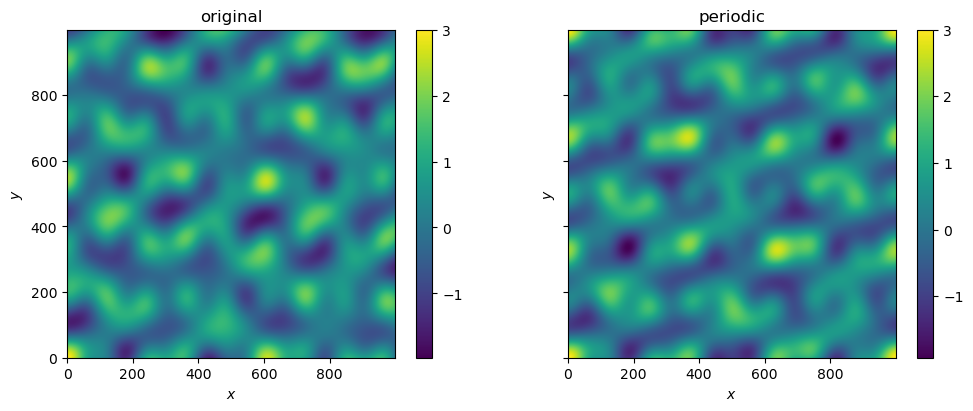

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True, constrained_layout=True)

fig.colorbar(axs[0].imshow(orig_ic, interpolation=None, origin="lower"));
axs[0].set_title("original");
axs[0].set_xlabel("$x$");
axs[0].set_ylabel("$y$");

fig.colorbar(axs[1].imshow(peri_ic, interpolation=None, origin="lower"));
axs[1].set_title("periodic");
axs[1].set_xlabel("$x$");
axs[1].set_ylabel("$y$");

## Use a $\sin$ interpolation *(it works!)*

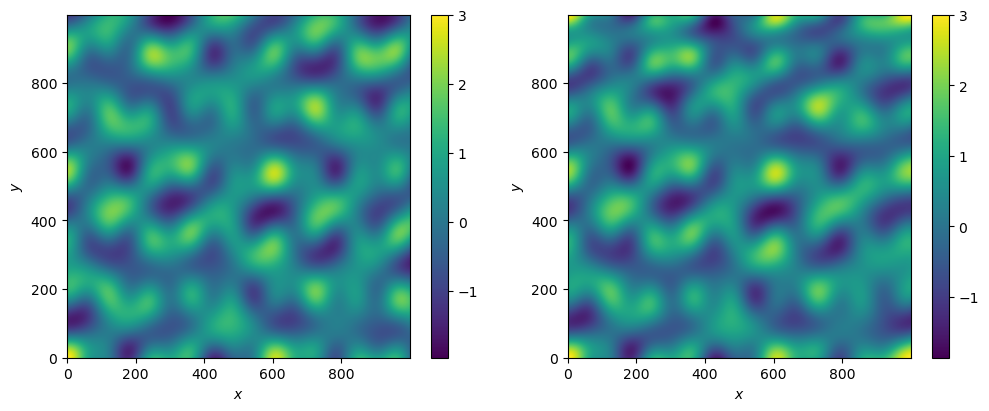

In [6]:
sic = lambda x: np.power(np.sin(np.pi * x / L), 2/3)

# use the numpy broadcast semantics to interpolate coefficients
mapX = sic(X)
mapY = sic(Y)

Ac = A0[:,None,None] * mapX + Ap[:,None,None] * (1 - mapX)
Bc = B0[:,None,None] * mapY + Bp[:,None,None] * (1 - mapY)

Z_orig = ic(X, Y, A0, B0)
Z_test = ic(X, Y, Ac, Bc)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False, constrained_layout=True)

fig.colorbar(axs[0].imshow(Z_orig, interpolation=None, origin="lower"));
axs[0].set_xlabel("$x$");
axs[0].set_ylabel("$y$");

fig.colorbar(axs[1].imshow(Z_test, interpolation=None, origin="lower"));
axs[1].set_xlabel("$x$");
axs[1].set_ylabel("$y$");

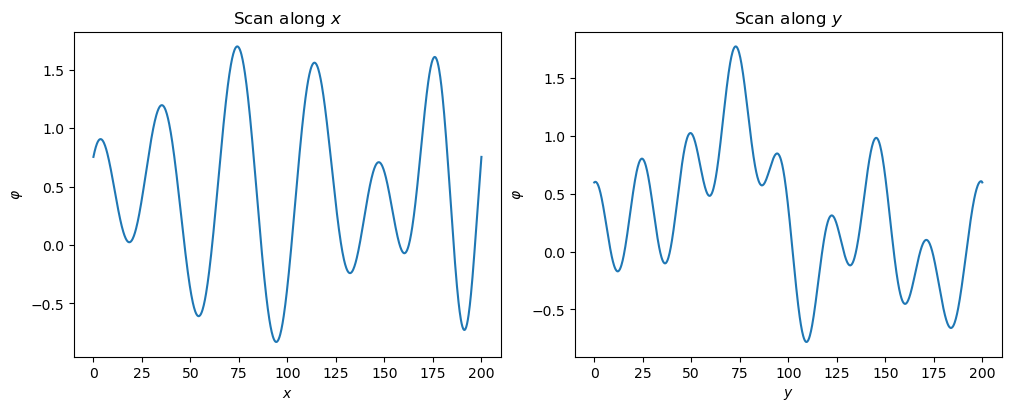

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False, constrained_layout=True)

axs[0].plot(x, Z_test[:,3*N//8])
axs[0].set_title("Scan along $x$")
axs[0].set_xlabel("$x$");
axs[0].set_ylabel("$\\varphi$");

axs[1].plot(x, Z_test[3*N//8,:])
axs[1].set_title("Scan along $y$")
axs[1].set_xlabel("$y$");
axs[1].set_ylabel("$\\varphi$");

In [8]:
l2x = LA.norm(Z_test[:,0] - Z_test[:,-1])
l2y = LA.norm(Z_test[0,:] - Z_test[-1,:])
print(f"L2-norm along x boundary: {l2x:.4e}")
print(f"L2-norm along x boundary: {l2y:.4e}")

L2-norm along x boundary: 7.5241e-10
L2-norm along x boundary: 1.0245e-09


## Fourier Series

The hybrid version is a bit messy to code: constant coefficients would be better.
To derive them, let's try a 2D Fourier series approximation.
For a 2D square domain of edge length $L$ and mesh resolution $h$:

$$
\begin{align}
f(x, y) & = \sum_{n=0}^{\infty}\sum\limits_{m=0}^{\infty} A_{n,m}\cos\left(\frac{2\pi n x}{L}\right)\cos\left(\frac{2\pi m y}{L}\right) \\
        & + \sum_{n=0}^{\infty}\sum\limits_{m=0}^{\infty} B_{n,m}\cos\left(\frac{2\pi n x}{L}\right)\sin\left(\frac{2\pi m y}{L}\right) \\
        & + \sum_{n=0}^{\infty}\sum\limits_{m=0}^{\infty} C_{n,m}\sin\left(\frac{2\pi n x}{L}\right)\cos\left(\frac{2\pi m y}{L}\right) \\
        & + \sum_{n=0}^{\infty}\sum\limits_{m=0}^{\infty} D_{n,m}\sin\left(\frac{2\pi n x}{L}\right)\sin\left(\frac{2\pi m y}{L}\right)
\end{align}
$$

$$
\begin{align}
A_{n,m} &= \frac{\kappa}{L^2}\sum\limits_{x=0}^{L}\sum\limits_{y=0}^{L}
                f(x,y)\cos\left(\frac{2\pi n x}{L}\right)\cos\left(\frac{2\pi m y}{L}\right) h^2 \\
B_{n,m} &= \frac{\kappa}{L^2}\sum\limits_{x=0}^{L}\sum\limits_{y=0}^{L}
                f(x,y)\cos\left(\frac{2\pi n x}{L}\right)\sin\left(\frac{2\pi m y}{L}\right) h^2 \\
C_{n,m} &= \frac{\kappa}{L^2}\sum\limits_{x=0}^{L}\sum\limits_{y=0}^{L}
                f(x,y)\sin\left(\frac{2\pi n x}{L}\right)\cos\left(\frac{2\pi m y}{L}\right) h^2 \\
D_{n,m} &= \frac{\kappa}{L^2}\sum\limits_{x=0}^{L}\sum\limits_{y=0}^{L}
                f(x,y)\sin\left(\frac{2\pi n x}{L}\right)\sin\left(\frac{2\pi m y}{L}\right) h^2
\end{align}
$$

$$
\kappa = \begin{cases}
1, & n = 0 & \land & m = 0 \\
2, & n = 0 & \lor  & m = 0 \\
4, & n> 0  & \land & m > 0
\end{cases}
$$

Consider the expansion with just 3 terms:

In [34]:
Nf = 12
Mf = 12
Xf = np.linspace(0, L, Nf)
Yf = np.linspace(0, L, Mf)
Xn, Yn = np.meshgrid(Xf, Yf, indexing="ij")
Nn, Mm = np.meshgrid(np.arange(Nf), np.arange(Mf), indexing="ij")

κ = np.ones(Xn.shape)
κ = np.where(np.all([Xn == 0, Yn == 0]), κ, np.where(np.any([Xn == 0, Yn == 0]), 2, 4))

Af = np.zeros(Xn.shape)
Bf = np.zeros(Xn.shape)
Cf = np.zeros(Xn.shape)
Df = np.zeros(Xn.shape)

for mf in range(Mf):
    for nf in range(Nf):
        cosX = np.cos(2*np.pi*nf/L * X)
        cosY = np.cos(2*np.pi*mf/L * Y)
        
        sinX = np.sin(2*np.pi*nf/L * X)
        sinY = np.sin(2*np.pi*mf/L * Y)
        
        Af[nf, mf] = dx**2 * κ[nf, mf] / L**2 * (Z_test * cosX * cosY).sum()
        Bf[nf, mf] = dx**2 * κ[nf, mf] / L**2 * (Z_test * cosX * sinY).sum()
        Cf[nf, mf] = dx**2 * κ[nf, mf] / L**2 * (Z_test * sinX * cosY).sum()
        Df[nf, mf] = dx**2 * κ[nf, mf] / L**2 * (Z_test * sinX * sinY).sum()

Range: (-0.2503, 0.5090)


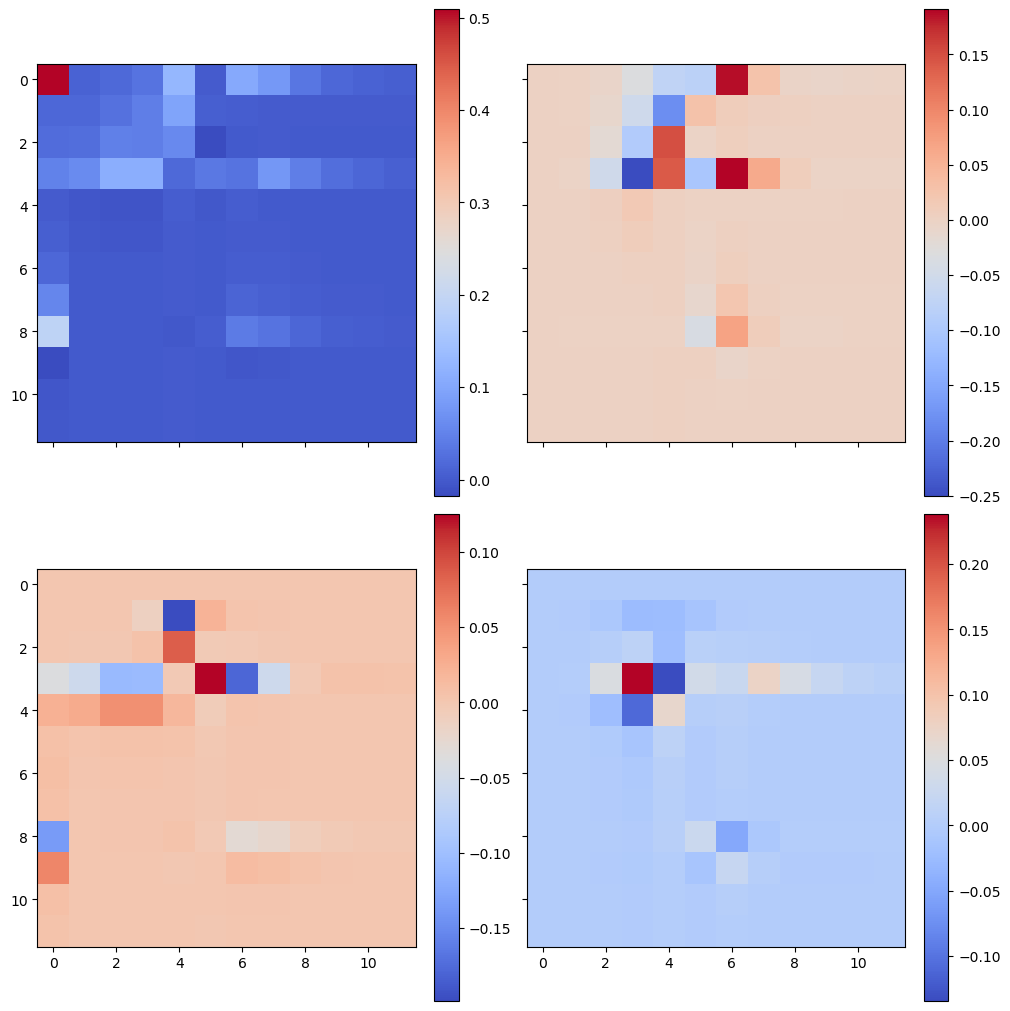

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()

Q = np.array([Af, Bf, Cf, Df])

vmin = np.amin(Q)
vmax = np.amax(Q)

print(f"Range: ({vmin:.4f}, {vmax:.4f})")

for i, q in enumerate(Q):
    cb = axs[i].imshow(q, interpolation=None, origin="upper", cmap="coolwarm")  # , vmin=vmin, vmax=0.25)
    fig.colorbar(cb)                   

From these matrices, it appears the most significant coefficients are:

* $A_{00} = 0.509$, $A_{04} = 0.128$, $A_{80} = 0.191$
* $B_{06} = 0.187$, $B_{15} =-0.180$, $B_{25} = 0.148$, $B_{34} =-0.250$, $B_{35} = 0.140$, $B_{36} = 0.191$ 
* $C_{14} =-0.199$, $C_{35} = 0.125$, $C_{36} =-0.179$, $C_{80} = -0.136$
* $D_{33} = 0.238$, $D_{34} = -0.134$

$$
\begin{align}
f(x, y) & = \sum_{n=0}^{\infty}\sum\limits_{m=0}^{\infty} A_{n,m}\cos\left(\frac{2\pi n x}{L}\right)\cos\left(\frac{2\pi m y}{L}\right) \\
        & + \sum_{n=0}^{\infty}\sum\limits_{m=0}^{\infty} B_{n,m}\cos\left(\frac{2\pi n x}{L}\right)\sin\left(\frac{2\pi m y}{L}\right) \\
        & + \sum_{n=0}^{\infty}\sum\limits_{m=0}^{\infty} C_{n,m}\sin\left(\frac{2\pi n x}{L}\right)\cos\left(\frac{2\pi m y}{L}\right) \\
        & + \sum_{n=0}^{\infty}\sum\limits_{m=0}^{\infty} D_{n,m}\sin\left(\frac{2\pi n x}{L}\right)\sin\left(\frac{2\pi m y}{L}\right)
\end{align}
$$

In [32]:
Π = 2 * np.pi / L

Fa = lambda x, y: Af[0, 0] \
                + Af[0, 4] * np.cos(4 * Π * x) \
                + Af[3, 5] * np.cos(3 * Π * x) * np.cos(5 * Π * y) \
                + Af[3, 6] * np.cos(3 * Π * x) * np.cos(6 * Π * y) \
                + Af[3, 7] * np.cos(3 * Π * x) * np.cos(7 * Π * y) \
                + Af[8, 0] * np.cos(8 * Π * y) \
                + Af[8, 6] * np.cos(8 * Π * x) * np.cos(6 * Π * y)

Fb = lambda x, y: Bf[0, 6] * np.sin(6 * Π * y) \
                + Bf[1, 5] * np.cos(    Π * x) * np.sin(5 * Π * y) \
                + Bf[2, 5] * np.cos(2 * Π * x) * np.sin(5 * Π * y) \
                + Bf[3, 4] * np.cos(3 * Π * x) * np.sin(4 * Π * y) \
                + Bf[3, 5] * np.cos(3 * Π * x) * np.sin(5 * Π * y) \
                + Bf[3, 6] * np.cos(3 * Π * x) * np.sin(6 * Π * y) \
                + Bf[3, 7] * np.cos(3 * Π * x) * np.sin(7 * Π * y) \
                + Bf[8, 6] * np.cos(8 * Π * x) * np.sin(6 * Π * y)

Fc = lambda x, y: Cf[1, 4] * np.sin(    Π * x) * np.cos(4 * Π * y) \
                + Cf[3, 5] * np.sin(3 * Π * x) * np.cos(5 * Π * y) \
                + Cf[3, 6] * np.sin(3 * Π * x) * np.cos(6 * Π * y) \
                + Cf[3, 7] * np.sin(3 * Π * x) * np.cos(7 * Π * y) \
                + Cf[8, 0] * np.sin(8 * Π * x) \
                + Cf[8, 6] * np.sin(8 * Π * x) * np.cos(6 * Π * y)

Fd = lambda x, y: Df[3, 3] * np.sin(3 * Π * x) * np.sin(3 * Π * y) \
                + Df[3, 4] * np.sin(3 * Π * x) * np.sin(4 * Π * y) \
                + Df[3, 5] * np.sin(3 * Π * x) * np.sin(5 * Π * y) \
                + Df[3, 6] * np.sin(3 * Π * x) * np.sin(6 * Π * y) \
                + Df[3, 7] * np.sin(3 * Π * x) * np.sin(7 * Π * y) \
                + Df[8, 6] * np.sin(8 * Π * x) * np.sin(6 * Π * y)


F = lambda x, y: 0.5 + 0.01 * (Fa(x, y) + Fb(x, y) + Fc(x, y) + Fd(x, y))

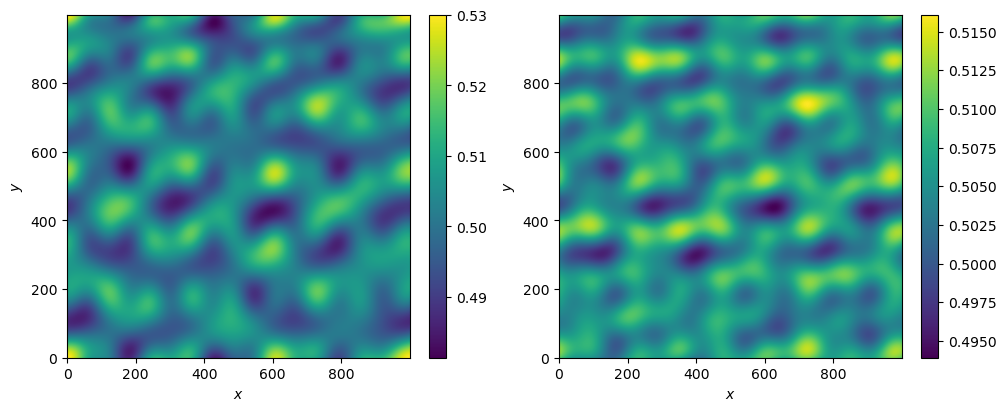

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False, constrained_layout=True)

fig.colorbar(axs[0].imshow(0.5 + 0.01 * Z_test, interpolation=None, origin="lower"));
axs[0].set_xlabel("$x$");
axs[0].set_ylabel("$y$");

fig.colorbar(axs[1].imshow(F(X, Y), interpolation=None, origin="lower"));
axs[1].set_xlabel("$x$");
axs[1].set_ylabel("$y$");